<a href="https://colab.research.google.com/github/JosstopherMaitland/Circularity_LLC/blob/main/Circularity_Modulus_Transformer_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Taking estimates of the LLC on pizza and clock models as described in the paper: https://arxiv.org/pdf/2306.17844.pdf

# Conceptual Notes

## Gradient Symmetricity
For a fixed set $S \subseteq \mathbb{Z}$
 - High gradient symmetricity indicates pizza algorithm.

## Distance Irrelevance

- Distance irrelevance ranges from 0 to 0.5 for *Pizza* algorithm and 0.5 to 1 for the *Clock* algorithm.

# Actual Code

## Setup

### Installs

In [ ]:
%pip install devinterp matplotlib transformers torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.7/93.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.0/215.0 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 370.9/370.9 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

### Imports

In [ ]:
from typing import Any, Callable, Literal, Dict, List, Tuple, Optional, Union

from itertools import product, permutations
import logging
import os
from pathlib import Path
import time

import numpy as np
import pydantic
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from dataclasses import dataclass
from pydantic import BaseModel

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm

In [ ]:
import einops

ModuleNotFoundError: No module named 'einops'

In [ ]:
from devinterp.slt import estimate_learning_coeff
from devinterp.zoo.arithmetic import ModularArithmeticConfig, ModularArithmetic
from devinterp.optim.sgld import SGLD

### Other

In [ ]:
logging.basicConfig(level=logging.INFO)

sns.set_palette("deep")
sns.set_style("whitegrid")

MODELS_PATH = Path("models")

if not os.path.exists(MODELS_PATH):
    os.makedirs(MODELS_PATH)

PRIMARY, SECONDARY, TERTIARY = sns.color_palette("deep")[:3]
PRIMARY_LIGHT, SECONDARY_LIGHT, TERTIARY_LIGHT = sns.color_palette("muted")[:3]

DEVICE = os.environ.get(
    "DEVICE",
    "cuda:0"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu",
)
DEVICE = torch.device(DEVICE)
NUM_CORES = int(os.environ.get("NUM_CORES", 1))

In [ ]:
DEVICE

device(type='cuda', index=0)

### Model

Create a generic transformer model with the attention rate hyper parameter as proposed in [The Clock and the Pizza](https://arxiv.org/pdf/2306.17844.pdf) Section 4.2. This is perhaps overkill, as I'm only interested in creating models A and B from the paper with attention rate $\alpha = 0$ and $\alpha = 1$ respectively. If I find time though, it would be interesting to study models with $\alpha \in (0,1)$.

- Attention is bidirectional.
 - no lower triangular mask, only softmax
- No LayerNorm.
- Attention rate.
- ReLU activation function

In [ ]:
scalar = 0
matrix = torch.tensor([[[1,2,3],[4,5,6],[7,8,9]], [[1,2,3],[4,5,6],[7,8,9]]])
print(scalar * matrix)
print((1-scalar) * torch.eye(3))
print(scalar * matrix + (1-scalar) * torch.eye(3))

tensor([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]])
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])
tensor([[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]])


In [ ]:
class Embed(nn.Module):
    def __init__(self, d_vocab: int, d_model: int):
        super().__init__()
        self.W_E = nn.Parameter(torch.randn(d_model, d_vocab) / np.sqrt(d_model))

    def forward(self, x):
        return torch.einsum("dbp -> bpd", self.W_E[:, x])


class Unembed(nn.Module):
    def __init__(self, d_vocab: int, d_model: int):
        super().__init__()
        self.W_U = nn.Parameter(torch.randn(d_model, d_vocab) / np.sqrt(d_vocab))

    def forward(self, x):
        return x @ self.W_U


class PosEmbed(nn.Module):
    def __init__(self, max_ctx: int, d_model: int):
        super().__init__()
        self.W_pos = nn.Parameter(torch.randn(max_ctx, d_model) / np.sqrt(d_model))

    def forward(self, x):
        return x + self.W_pos[: x.shape[-2]]


class Attention(nn.Module):
    def __init__(self, d_model, num_heads, d_head, num_ctx, attn_rate):
        super().__init__()
        self.W_K = nn.Parameter(torch.randn(num_heads, d_head, d_model) / np.sqrt(d_model))
        self.W_Q = nn.Parameter(torch.randn(num_heads, d_head, d_model) / np.sqrt(d_model))
        self.W_V = nn.Parameter(torch.randn(num_heads, d_head, d_model) / np.sqrt(d_model))
        self.W_O = nn.Parameter(torch.randn(d_model, d_head * num_heads) / np.sqrt(d_model))
        self.d_head = d_head
        self.attn_rate = attn_rate
        self.identity = torch.eye(num_ctx, device = DEVICE)

    def forward(self, x):
        k = torch.einsum("ihd,bpd->biph", self.W_K, x)
        q = torch.einsum("ihd,bpd->biph", self.W_Q, x)
        v = torch.einsum("ihd,bpd->biph", self.W_V, x)
        attn_scores_pre = torch.einsum("biph,biqh->biqp", k, q)

        attn_matrix = F.softmax(attn_scores_pre / np.sqrt(self.d_head), dim=-1)

        interp_attn_matrix = self.attn_rate * attn_matrix + (1 - self.attn_rate) * self.identity

        z = torch.einsum("biph,biqp->biqh", v, interp_attn_matrix)
        z_flat = einops.rearrange(z, "b i q h -> b q (i h)")
        out = torch.einsum("df,bqf->bqd", self.W_O, z_flat)
        return out


class MLP(nn.Module):
    def __init__(self, d_model: int, d_mlp: int, act_fn: Callable = F.relu):
        super().__init__()
        self.W_in = nn.Parameter(torch.randn(d_mlp, d_model) / np.sqrt(d_model))
        self.b_in = nn.Parameter(torch.zeros(d_mlp))
        self.W_out = nn.Parameter(torch.randn(d_model, d_mlp) / np.sqrt(d_model))
        self.b_out = nn.Parameter(torch.zeros(d_model))
        self.act_fn = act_fn

    def forward(self, x):
        x = torch.einsum("md,bpd->bpm", self.W_in, x) + self.b_in
        x = self.act_fn(x)
        x = torch.einsum("dm,bpm->bpd", self.W_out, x) + self.b_out

        return x


class TransformerBlock(nn.Module):
    def __init__(
        self,
        d_model: int,
        d_mlp: int,
        d_head: int,
        num_heads: int,
        num_ctx: int,
        attn_rate: int,
        act_fn: Callable = F.relu,
    ):
        super().__init__()
        self.attn = Attention(d_model, num_heads, d_head, num_ctx, attn_rate)
        self.mlp = MLP(d_model, d_mlp, act_fn)

    def forward(self, x):
        x = x + self.attn(x)
        x = x + self.mlp((x))
        return x


class Transformer(nn.Module):
    def __init__(
        self,
        num_layers: int,
        d_vocab: int,
        d_model: int,
        d_mlp: int,
        d_head: int,
        num_heads: int,
        num_ctx: int,
        attn_rate: int,
        act_fn: Callable = F.relu,
    ):
        super().__init__()

        self.embed = Embed(d_vocab, d_model)
        self.pos_embed = PosEmbed(num_ctx, d_model)
        self.blocks = nn.ModuleList(
            [
                TransformerBlock(d_model, d_mlp, d_head, num_heads, num_ctx, attn_rate, act_fn)
                for i in range(num_layers)
            ]
        )
        self.unembed = Unembed(d_vocab, d_model)

    def forward(self, x):
        x = self.embed(x)
        x = self.pos_embed(x)

        for block in self.blocks:
            x = block(x)

        x = self.unembed(x)
        return x

In [ ]:
MODULUS = 59
DIMENSION = 128

@dataclass
class TransformerConfig:
    num_layers: int = 1
    d_vocab: int = MODULUS + 1
    d_model: int = DIMENSION
    d_mlp: int = 4 * DIMENSION
    d_head: int = DIMENSION // 4
    num_heads: int = 4
    num_ctx: int = 3
    act_fn: Callable = F.relu
    attn_rate: int = 0

    def factory(self):

        return Transformer(
            num_layers=self.num_layers,
            d_vocab=self.d_vocab,
            d_model=self.d_model,
            d_mlp=self.d_mlp,
            d_head=self.d_head,
            num_heads=self.num_heads,
            num_ctx=self.num_ctx,
            act_fn=self.act_fn,
            attn_rate=self.attn_rate
        )

2 models for each attention rate. Attention rate = 0 doesn't seem to reach 100% train accuracy or validation accuracy.

By varying attention rates, we may be able to control for (or get some preliminary results on the learning coefficients for) the pizza and clock algorithms.

In [ ]:
ATTN_RATES = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

### Evals

In [ ]:
def cross_entropy_last_token(outputs, targets, reduction="sum"):
    """
    Wrapper around cross entropy loss because we only care about the last number predicted.
    """
    # Only look at predictions of last numbers
    outputs = outputs[:, -1]

    # Compute individual and summed losses for final number
    logprobs = F.log_softmax(outputs.to(torch.float32), dim=-1)
    prediction_logprobs = torch.gather(logprobs, index=targets.unsqueeze(1), dim=-1)

    if reduction == "mean":
        loss = -torch.mean(prediction_logprobs)
    elif reduction == "sum":
        loss = -torch.sum(prediction_logprobs)
    else:
        raise ValueError("Invalid reduction argument.")

    return loss


def make_evals(trainset: ModularArithmetic, testset: ModularArithmetic, device: str):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=False)

    def eval_loss_and_acc(model: nn.Module) -> Dict[str, float]:
        model.eval()

        results = {}

        for name, loader in zip(["train", "test"], [trainloader, testloader]):
            total = 0
            correct = 0

            for x, y in loader:
                x = x.to(device)
                y = y.to(device)

                with torch.no_grad():
                    y_hat = model(x)

                total += cross_entropy_last_token(y_hat, y, reduction="sum").item()
                correct += (
                    (y_hat[:, -1, :].max(dim=1).indices == y).sum().item()
                )  # argmax doesn't work for device=mps

            results[f"{name}/loss"] = total / len(loader.dataset)
            results[f"{name}/accuracy"] = correct / len(loader.dataset)

        return results

    return eval_loss_and_acc

### Learner Class

In [ ]:
@dataclass
class Learner:
    config: "GrokkingConfig"
    model: nn.Module
    dataset: torch.utils.data.Dataset
    loader: torch.utils.data.DataLoader
    optimizer: torch.optim.Optimizer
    evals: Callable[[nn.Module], Dict[str, float]]

class GrokkingConfig(BaseModel):
    data: ModularArithmeticConfig
    model: TransformerConfig
    noise_level: float = 1.0
    batch_size: int = 256
    num_steps: int = 20_000
    device: str = "cuda"
    lr: float = 1e-3
    betas: Tuple[float, float] = (0.9, 0.98)
    weight_decay: float = 0.2

    class Config:
        arbitrary_types_allowed = True

    @property
    def num_training_examples(self):
        return int((self.data.modulus**2) * self.data.split)

    def create_model(self):
        return self.model.factory()

    def create_data(self):
        return self.data.factory_split()

    def create_learner(self):
        model = self.create_model()
        trainset, testset = self.create_data()
        trainloader = torch.utils.data.DataLoader(
            trainset, batch_size=self.batch_size, shuffle=True
        )
        evals = make_evals(trainset, testset, self.device)
        optimizer = optim.AdamW(
            model.parameters(),
            lr=self.lr,
            betas=self.betas,
            weight_decay=self.weight_decay,
        )

        learner = Learner(self, model, trainset, trainloader, optimizer, evals)
        return learner

In [ ]:
mod_data = ModularArithmeticConfig(operator="+", modulus=MODULUS, seed=0, split=0.8)

In [ ]:
learners = {}
for a in ATTN_RATES:
  torch.manual_seed(a*10)
  learner0 = GrokkingConfig(
      data = mod_data,
      model = TransformerConfig(attn_rate = a),
      device = str(DEVICE),
  ).create_learner()

  torch.manual_seed(10+10*a)
  learner1 = GrokkingConfig(
      data = mod_data,
      model = TransformerConfig(attn_rate = a),
      device = str(DEVICE),
  ).create_learner()

  learners[a] = [learner0, learner1]

In [ ]:
learners[0.2][1].model.embed.W_E

Parameter containing:
tensor([[-0.0117, -0.0111,  0.0304,  ..., -0.0797, -0.1688, -0.0883],
        [-0.0907,  0.0861, -0.1630,  ..., -0.0156,  0.0758,  0.0829],
        [-0.0083,  0.0553, -0.2066,  ...,  0.0808, -0.1134,  0.0938],
        ...,
        [ 0.0105, -0.0420,  0.0321,  ..., -0.1251,  0.0680, -0.0224],
        [ 0.0124,  0.0079,  0.0187,  ..., -0.0155, -0.0239,  0.0389],
        [ 0.0938,  0.0271, -0.0302,  ...,  0.1732,  0.1087,  0.0195]],
       requires_grad=True)

In [ ]:
learners[0.2][0].model.embed.W_E

Parameter containing:
tensor([[-0.0920,  0.0810, -0.1153,  ..., -0.1063, -0.0516, -0.0390],
        [-0.1749,  0.0688, -0.0685,  ...,  0.1343, -0.0433,  0.0816],
        [-0.0531, -0.0987,  0.0228,  ...,  0.0280, -0.0793, -0.0565],
        ...,
        [-0.0227,  0.1120,  0.0775,  ..., -0.1761, -0.0297,  0.1243],
        [ 0.0498,  0.1614, -0.0619,  ..., -0.1843,  0.0591,  0.0499],
        [-0.0152,  0.0961, -0.0042,  ..., -0.0007, -0.0334,  0.0526]],
       requires_grad=True)

### Training

Removed all mentions of WandB

In [ ]:
def train(learner, CHECKPOINTS_PATH, num_log_ivl_steps=100, num_lin_ivl_steps=100):
    learner.model.to(learner.config.device)
    learner.model.train()

    evals = []

    num_steps = learner.config.num_steps
    logging_steps = set(np.linspace(0, num_steps, num_lin_ivl_steps).astype(int)) | set(
        np.logspace(0, num_steps, num_log_ivl_steps).astype(int)
    )

    def log(step):
        learner.model.eval()
        evals.append({"step": step, **learner.evals(learner.model)})

        learner.model.train()


    def save_checkpoint(step):
        torch.save(learner.model.state_dict(), f"{CHECKPOINTS_PATH}_{step}.pt")

    step = -1
    epoch = -1

    pbar = tqdm(
        total=learner.config.num_steps,
        desc=f"Training...",
    )

    while step < learner.config.num_steps:
        torch.manual_seed(step)
        epoch += 1

        for x, y in learner.loader:
            step += 1
            x, y = x.to(learner.config.device), y.to(learner.config.device)
            learner.optimizer.zero_grad()
            y_hat = learner.model(x)
            loss = cross_entropy_last_token(y_hat, y)
            loss.backward()
            learner.optimizer.step()

            if step in logging_steps:
                log(step=step)
                save_checkpoint(step=step)

            pbar.update(1)

    if pbar:
        pbar.close()

    log(step=step)
    save_checkpoint(step=step) # save final model

    evals_df = pd.DataFrame(evals)
    evals_df.sort_values("step", inplace=True)

    return evals_df

In [ ]:
for attn_rate, learner_arr in learners.items():
  print(f"ATTENTION RATE : {attn_rate}, MODEL 0")
  path = MODELS_PATH / f"attn_rate{attn_rate}_0"
  os.makedirs(path)
  print(train(learner_arr[0], path, num_log_ivl_steps=0, num_lin_ivl_steps=4))

  print(f"ATTENTION RATE : {attn_rate}, MODEL 1")
  path = MODELS_PATH / f"attn_rate{attn_rate}_1"
  os.makedirs(path)
  print(train(learner_arr[1], path, num_log_ivl_steps=0, num_lin_ivl_steps=4))

ATTENTION RATE : 0.1, MODEL 0


Training...: 20009it [02:53, 115.05it/s]                           


    step    train/loss  train/accuracy     test/loss  test/accuracy
0      0  4.137346e+00        0.015086  4.118322e+00       0.020086
1   6666  1.352749e-05        1.000000  2.173772e-05       1.000000
2  13333  1.067444e-06        1.000000  1.944281e-06       1.000000
3  20000  2.268144e-07        1.000000  4.118445e-07       1.000000
4  20008  3.239287e-07        1.000000  6.350380e-07       1.000000
ATTENTION RATE : 0.1, MODEL 1


Training...: 20009it [02:49, 117.76it/s]                           


    step  train/loss  train/accuracy  test/loss  test/accuracy
0      0    4.117422        0.016523   4.126999       0.018651
1   6666    0.000040        1.000000   0.000054       1.000000
2  13333    0.000129        1.000000   0.000154       1.000000
3  20000    0.000156        1.000000   0.000187       1.000000
4  20008    0.000150        1.000000   0.000179       1.000000
ATTENTION RATE : 0.2, MODEL 0


Training...: 20009it [02:51, 116.81it/s]                           


    step  train/loss  train/accuracy  test/loss  test/accuracy
0      0    4.108068        0.014368   4.099782       0.027260
1   6666    0.012824        0.998922   0.303571       0.977044
2  13333    0.000954        1.000000   0.200326       0.992826
3  20000    0.000129        1.000000   0.215577       0.989957
4  20008    0.000134        1.000000   0.214214       0.989957
ATTENTION RATE : 0.2, MODEL 1


Training...: 20009it [02:51, 116.82it/s]


    step    train/loss  train/accuracy     test/loss  test/accuracy
0      0  4.110819e+00        0.017960  4.132641e+00       0.015782
1   6666  1.613008e-07        1.000000  2.946878e-07       1.000000
2  13333  4.041647e-05        1.000000  4.964385e-05       1.000000
3  20000  3.175401e-03        0.998563  1.804058e-03       1.000000
4  20008  1.568427e-01        0.946121  1.676130e-01       0.939742
ATTENTION RATE : 0.3, MODEL 0


Training...: 20009it [02:51, 116.95it/s]                           


    step    train/loss  train/accuracy     test/loss  test/accuracy
0      0  4.126754e+00        0.019397  4.129379e+00       0.007174
1   6666  2.039489e-07        1.000000  3.906367e-07       1.000000
2  13333  5.102182e-05        1.000000  8.789340e-05       1.000000
3  20000  5.768193e-05        1.000000  6.942991e-05       1.000000
4  20008  5.652259e-05        1.000000  6.794523e-05       1.000000
ATTENTION RATE : 0.3, MODEL 1


Training...: 20009it [02:47, 119.52it/s]                           


    step  train/loss  train/accuracy  test/loss  test/accuracy
0      0    4.124863        0.016882   4.131470       0.017217
1   6666    0.000117        1.000000   0.000221       1.000000
2  13333    0.000046        1.000000   0.000056       1.000000
3  20000    0.000002        1.000000   0.000003       1.000000
4  20008    0.000002        1.000000   0.000003       1.000000
ATTENTION RATE : 0.4, MODEL 0


Training...: 20009it [02:48, 119.04it/s]                           


    step    train/loss  train/accuracy     test/loss  test/accuracy
0      0  4.115154e+00        0.015445  4.118983e+00       0.020086
1   6666  1.796229e-06        1.000000  4.380033e-06       1.000000
2  13333  1.760956e-05        1.000000  2.454084e-05       1.000000
3  20000  3.083854e-07        1.000000  5.722715e-07       1.000000
4  20008  2.825653e-07        1.000000  5.346446e-07       1.000000
ATTENTION RATE : 0.4, MODEL 1


Training...: 20009it [02:46, 120.18it/s]


    step    train/loss  train/accuracy     test/loss  test/accuracy
0      0  4.122675e+00         0.01796  4.136428e+00       0.014347
1   6666  2.959974e-05         1.00000  8.365802e-04       1.000000
2  13333  7.234773e-04         1.00000  3.677467e-03       0.998565
3  20000  2.127269e-07         1.00000  3.466816e-07       1.000000
4  20008  1.935438e-07         1.00000  3.121332e-07       1.000000
ATTENTION RATE : 0.5, MODEL 0


Training...: 20009it [02:48, 118.83it/s]


    step    train/loss  train/accuracy  test/loss  test/accuracy
0      0  4.119503e+00        0.015805   4.122170       0.022956
1   6666  4.106382e-08        1.000000   0.000028       1.000000
2  13333  6.595198e-06        1.000000   0.000078       1.000000
3  20000  1.074947e-05        1.000000   0.000260       1.000000
4  20008  1.089294e-05        1.000000   0.000253       1.000000
ATTENTION RATE : 0.5, MODEL 1


Training...: 20009it [02:42, 122.89it/s]                           


    step    train/loss  train/accuracy     test/loss  test/accuracy
0      0  4.113034e+00        0.014009  4.117233e+00       0.018651
1   6666  2.263077e-02        0.993175  4.871823e-02       0.982783
2  13333  2.057951e-05        1.000000  2.403752e-05       1.000000
3  20000  5.857697e-08        1.000000  8.825248e-08       1.000000
4  20008  5.746366e-08        1.000000  8.158223e-08       1.000000
ATTENTION RATE : 0.6, MODEL 0


Training...: 20009it [02:49, 117.97it/s]


    step    train/loss  train/accuracy  test/loss  test/accuracy
0      0  4.115988e+00        0.017241   4.111241       0.020086
1   6666  9.630088e-08        1.000000   0.000027       1.000000
2  13333  2.991825e-06        1.000000   0.000005       1.000000
3  20000  1.392885e-05        1.000000   0.000022       1.000000
4  20008  1.391992e-05        1.000000   0.000021       1.000000
ATTENTION RATE : 0.6, MODEL 1


Training...: 20009it [02:52, 116.11it/s]


    step    train/loss  train/accuracy     test/loss  test/accuracy
0      0  4.116773e+00        0.015805  4.131273e+00       0.017217
1   6666  1.313895e-05        1.000000  4.370150e-05       1.000000
2  13333  9.398863e-08        1.000000  6.476916e-07       1.000000
3  20000  6.607888e-07        1.000000  2.098681e-06       1.000000
4  20008  6.068792e-07        1.000000  1.949548e-06       1.000000
ATTENTION RATE : 0.7, MODEL 0


Training...: 20009it [02:46, 120.43it/s]


    step  train/loss  train/accuracy  test/loss  test/accuracy
0      0    4.119123        0.018678   4.125973       0.007174
1   6666    0.000015        1.000000   0.000229       1.000000
2  13333    0.000002        1.000000   0.000006       1.000000
3  20000    0.000015        1.000000   0.000021       1.000000
4  20008    0.000015        1.000000   0.000021       1.000000
ATTENTION RATE : 0.7, MODEL 1


Training...: 20009it [02:53, 115.03it/s]


    step    train/loss  train/accuracy  test/loss  test/accuracy
0      0  4.121050e+00        0.016164   4.125096       0.012912
1   6666  3.056450e-07        1.000000   0.000002       1.000000
2  13333  1.362590e-05        1.000000   0.000020       1.000000
3  20000  1.996318e-03        0.999641   0.003921       0.998565
4  20008  2.875202e-03        0.998922   0.006507       0.995696
ATTENTION RATE : 0.8, MODEL 0


Training...: 20009it [02:53, 115.31it/s]                           


    step    train/loss  train/accuracy  test/loss  test/accuracy
0      0  4.123406e+00        0.015445   4.131964       0.011478
1   6666  2.980232e-08        1.000000   0.000001       1.000000
2  13333  6.262599e-06        1.000000   0.000015       1.000000
3  20000  8.580751e-06        1.000000   0.000013       1.000000
4  20008  8.684124e-06        1.000000   0.000013       1.000000
ATTENTION RATE : 0.8, MODEL 1


Training...: 20009it [02:46, 120.17it/s]                           


    step    train/loss  train/accuracy     test/loss  test/accuracy
0      0  4.116007e+00        0.018319  4.127214e+00       0.014347
1   6666  4.157766e-08        1.000000  1.653878e-07       1.000000
2  13333  1.964246e-05        1.000000  2.614429e-05       1.000000
3  20000  1.309845e-06        1.000000  2.006199e-06       1.000000
4  20008  1.205665e-06        1.000000  1.826274e-06       1.000000
ATTENTION RATE : 0.9, MODEL 0


Training...: 20009it [02:43, 122.20it/s]                           


    step    train/loss  train/accuracy  test/loss  test/accuracy
0      0  4.139097e+00        0.011494   4.130116       0.017217
1   6666  1.076973e-01        0.968032   0.207353       0.956958
2  13333  2.251365e-05        1.000000   0.000033       1.000000
3  20000  8.524057e-07        1.000000   0.000001       1.000000
4  20008  7.796556e-07        1.000000   0.000001       1.000000
ATTENTION RATE : 0.9, MODEL 1


Training...: 20009it [02:47, 119.30it/s]


    step    train/loss  train/accuracy  test/loss  test/accuracy
0      0  4.113367e+00        0.017601   4.118465       0.012912
1   6666  6.222087e-07        1.000000   0.000012       1.000000
2  13333  1.741677e-05        1.000000   0.000067       1.000000
3  20000  2.070914e-06        1.000000   0.000005       1.000000
4  20008  1.908844e-06        1.000000   0.000004       1.000000
ATTENTION RATE : 1, MODEL 0


Training...: 20009it [02:47, 119.16it/s]                           


    step    train/loss  train/accuracy     test/loss  test/accuracy
0      0  4.110788e+00        0.014727  4.108783e+00       0.022956
1   6666  9.925542e-08        1.000000  3.372742e-07       1.000000
2  13333  2.252854e-06        1.000000  3.180666e-06       1.000000
3  20000  2.764342e-05        1.000000  3.516510e-05       1.000000
4  20008  2.713555e-05        1.000000  3.477466e-05       1.000000
ATTENTION RATE : 1, MODEL 1


Training...: 20009it [02:45, 120.69it/s]

    step    train/loss  train/accuracy  test/loss  test/accuracy
0      0  4.141943e+00        0.019397   4.140134       0.017217
1   6666  2.256584e-08        1.000000   0.000001       1.000000
2  13333  5.535966e-06        1.000000   0.000010       1.000000
3  20000  1.255577e-05        1.000000   0.000027       1.000000
4  20008  1.239669e-05        1.000000   0.000027       1.000000


In [ ]:
learners[0.2][0].model([[37,53,59]])[0,-1].argmax()

tensor(31, device='cuda:0')

In [ ]:
for name, param in learners[0.2][0].model.named_parameters():
  print(name, param.data)

embed.W_E tensor([[ 5.6105e-02,  9.9426e-03, -9.3394e-02,  ...,  1.7277e-02,
          4.3362e-02,  2.5916e-02],
        [-1.3514e-02, -1.6675e-02, -5.7600e-02,  ...,  1.1436e-02,
          2.9251e-01,  2.3988e-03],
        [ 1.3698e-01, -1.4830e-03, -4.3085e-02,  ..., -5.2998e-02,
          3.0785e-03,  4.9781e-03],
        ...,
        [-1.2376e-01, -1.0134e-02,  2.8487e-02,  ...,  1.1700e-02,
         -1.4693e-02,  8.0188e-02],
        [-6.5846e-02, -1.1284e-01,  2.3809e-03,  ...,  3.7248e-02,
          4.0948e-02, -2.1076e-04],
        [ 7.1310e-02,  2.0719e-02, -6.2224e-02,  ..., -4.4086e-02,
          6.6337e-03,  3.7492e-02]], device='cuda:0')
pos_embed.W_pos tensor([[-2.1243e-02, -6.1184e-03, -5.5051e-03, -1.2674e-02,  3.0466e-02,
          1.4666e-02, -1.0247e-02,  5.7747e-03, -2.8433e-02, -3.5039e-02,
          2.1498e-02, -2.0979e-02, -1.5336e-02,  3.1583e-03,  5.6914e-03,
          1.5577e-03,  6.1629e-04,  1.6493e-02,  6.0664e-03,  3.2711e-02,
         -2.0336e-03,  1.5548

## Circularity

### Principle Component Analysis

In [ ]:
data = torch.tensor([[1,1,2,2,3,3],[2,3,1,3,1,2],[3,2,3,1,2,1]], dtype=float)

In [ ]:
print(data)
print((data - torch.mean(data, dim = 0))/torch.std(data, dim = 0))

tensor([[1., 1., 2., 2., 3., 3.],
        [2., 3., 1., 3., 1., 2.],
        [3., 2., 3., 1., 2., 1.]], dtype=torch.float64)
tensor([[-1., -1.,  0.,  0.,  1.,  1.],
        [ 0.,  1., -1.,  1., -1.,  0.],
        [ 1.,  0.,  1., -1.,  0., -1.]], dtype=torch.float64)


In [ ]:
def PCA(matrix, num_comp):
  mean = torch.mean(matrix, dim=0)
  std_dev = torch.std(matrix, dim=0)

  scaled_matrix = (matrix - mean)/std_dev # column-wise normalisation

  U, S, V = torch.svd(scaled_matrix) # Singular Value Decomposition

  return V[:, :num_comp]

In [ ]:
PCA(data, 3)

tensor([[-1., -1.,  0.,  0.,  1.,  1.],
        [ 0.,  1., -1.,  1., -1.,  0.],
        [ 1.,  0.,  1., -1.,  0., -1.]], dtype=torch.float64) tensor([1., 1., 1., 1., 1., 1.], dtype=torch.float64)


tensor([[-0.5000,  0.2887, -0.1543],
        [-0.5000, -0.2887, -0.3086],
        [ 0.0000,  0.5774, -0.3086],
        [ 0.0000, -0.5774,  0.3086],
        [ 0.5000,  0.2887,  0.3086],
        [ 0.5000, -0.2887, -0.7715]], dtype=torch.float64)

### Circularity Calculation

In [ ]:
def circularity(p_comps):
  circ_sum = 0
  for l in range(4):

    Vl = p_comps[:,l]
    p_comp_squ_sum = torch.sum(torch.square(Vl))
    max_mag = 0

    for k in range(1,MODULUS):

      vect_sum = torch.tensor([0,0], dtype=float, device=DEVICE)
      for j in range(MODULUS):
        angle = (2 * j * k * np.pi) / MODULUS
        vect_sum += Vl[j] * torch.tensor([np.cos(angle), np.sin(angle)], device=DEVICE)
      vect_mag_squ = torch.sum(torch.square(vect_sum))

      if vect_mag_squ > max_mag:
        max_mag = vect_mag_squ

    circ_sum += 2 * max_mag / (MODULUS * p_comp_squ_sum)

  return circ_sum / 4

## Other Metrics

In [ ]:
def gradient_symmetricity(inp_out_tuples, model):
  cossim = nn.CosineSimilarity(dim=-1, eps=1e-6)
  cos_sim_sum = 0
  for a,b,c in inp_out_tuples:
    model.zero_grad()
    model([[a,b,MODULUS]])[0,-1, c].backward()
    a_grad = model.embed.W_E.grad[:,a]
    b_grad = model.embed.W_E.grad[:,b]
    #print(a_grad, b_grad)
    cos_sim_sum += cossim(a_grad, b_grad)
  model.zero_grad()
  return cos_sim_sum / (len(inp_out_tuples))

In [ ]:
inp_out_tuples = [(a,b,c) for a,b,c in product(range(0, MODULUS, 8), range(0, MODULUS, 9), range(0, MODULUS, 9))]

In [ ]:
inp_out_tuples

In [ ]:
def distance_irrelevance(correct_logits):
  std_sum = 0
  for d in range(MODULUS):
    std_sum += torch.std(torch.tensor([correct_logits[i,(i+d) % 59] for i in range(MODULUS)]))
  return std_sum / (MODULUS * torch.std(correct_logits))

In [ ]:
def get_correct_logits(model):
  correct_logits = torch.zeros((MODULUS, MODULUS))

  for i, j in product(range(MODULUS), range(MODULUS)):
    correct_logits[i,j] = model([[i,j,MODULUS]])[0,-1, (i + j)%MODULUS]

  return correct_logits

In [ ]:
def get_correct_logits_sum_diff_index(model):
  correct_logits = torch.zeros((MODULUS, MODULUS))

  for i, j in product(range(MODULUS), range(MODULUS)):
    sum = (i + j) % MODULUS
    diff = (i - j) % MODULUS
    correct_logits[diff,sum] = model([[i,j,MODULUS]])[0,-1, sum]

  return correct_logits

## Load Saved Models

In [ ]:
string = 'eggbacon'
string[3:]

'bacon'

In [ ]:
all_models = {}
pathlist = Path("models/models").glob('*.pt')
for path in pathlist:
  path_in_str = str(path)[14:]
  attn_rate = float(path_in_str.split('_')[0])
  model = TransformerConfig(attn_rate = attn_rate).factory()
  model.load_state_dict(torch.load(path))
  model.eval()
  model.to(DEVICE)
  try:
    all_models[attn_rate] += [model]
  except:
    all_models[attn_rate] = [model]

In [ ]:
all_models[0.3][0]([[4,20,59]])[0,-1].argmax()

tensor(24, device='cuda:0')

### Categorising Models by Circularity

In [ ]:
arr = torch.tensor([[1,2,3],[4,5,6]])
arr[:,:-1]

tensor([[1, 2],
        [4, 5]])

In [ ]:
circular_models = []
for attn_rate, model_arr in all_models.items():
  for i in range(len(model_arr)):
    if circularity(PCA(model_arr[i].embed.W_E[:,:-1], 4)) > 0.995: # remove last column as not number
      circular_models.append([attn_rate, i])

In [ ]:
circular_models

[[0.8, 5],
 [0.8, 6],
 [0.1, 2],
 [0.1, 6],
 [0.1, 7],
 [0.3, 0],
 [0.3, 1],
 [0.3, 2],
 [0.3, 3],
 [0.3, 4],
 [0.3, 6]]

In [ ]:
circularity(PCA(all_models[0.3][6].embed.W_E[:-1], 4))

tensor(0.9973, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)

In [ ]:
prim_comps = PCA(all_models[0.8][5].embed.W_E[:,:-1], 4).to('cpu').detach().numpy()

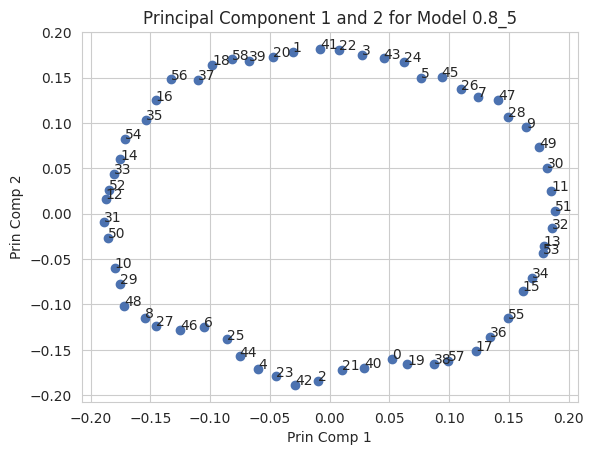

In [ ]:
fig, ax = plt.subplots()
ax.scatter(prim_comps[:,0], prim_comps[:,1])

for i, txt in enumerate(range(MODULUS)):
  ax.annotate(txt, (prim_comps[:,0][i], prim_comps[:,1][i]))

plt.title("Principal Component 1 and 2 for Model 0.8_5")
plt.xlabel("Prin Comp 1")
plt.ylabel("Prin Comp 2")
plt.show()

### Checking grad symm and dist irre for circular models

In [ ]:
for attn_rate, index in circular_models:
  print(f"{attn_rate}, {index}:")
  dist_irr = distance_irrelevance(get_correct_logits(all_models[attn_rate][index]))
  grad_sym = gradient_symmetricity(inp_out_tuples, all_models[attn_rate][index])
  print(f"Distance Irrelevance: {dist_irr}, Gradient Symmetricity: {grad_sym}")

0.8, 5:
Distance Irrelevance: 0.7923503518104553, Gradient Symmetricity: 0.1602788269519806
0.8, 6:
Distance Irrelevance: 0.7929936647415161, Gradient Symmetricity: 0.15905827283859253
0.1, 2:
Distance Irrelevance: 0.6869930028915405, Gradient Symmetricity: -0.4826442003250122
0.1, 6:
Distance Irrelevance: 0.6753953695297241, Gradient Symmetricity: -0.4664197266101837
0.1, 7:
Distance Irrelevance: 0.6635627150535583, Gradient Symmetricity: -0.48099735379219055
0.3, 0:
Distance Irrelevance: 0.8364670872688293, Gradient Symmetricity: -0.19794289767742157
0.3, 1:
Distance Irrelevance: 0.9838558435440063, Gradient Symmetricity: -0.12384765595197678
0.3, 2:
Distance Irrelevance: 0.8353205919265747, Gradient Symmetricity: -0.04728462174534798
0.3, 3:
Distance Irrelevance: 0.869074285030365, Gradient Symmetricity: -0.1375124156475067
0.3, 4:
Distance Irrelevance: 0.9840509295463562, Gradient Symmetricity: -0.12561973929405212
0.3, 6:
Distance Irrelevance: 0.7417980432510376, Gradient Symmetri

According to the paper, we would classify all these models as clock, except possibly (0.1, 2), (0.1, 6) and (0.1, 7) which might just be pizzas (this coincides with the idea that low attention circular models should yield pizzas, but this clearly poor evidence to that hypothesis generally).

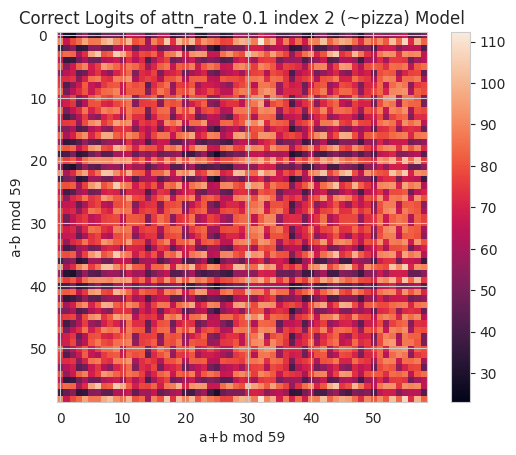

In [ ]:
plt.imshow(get_correct_logits_sum_diff_index(all_models[0.1][2]).detach().numpy())
plt.colorbar()
plt.title('Correct Logits of attn_rate 0.1 index 2 (~pizza) Model')
plt.xlabel(f'a+b mod {MODULUS}')
plt.ylabel(f'a-b mod {MODULUS}')
plt.show()

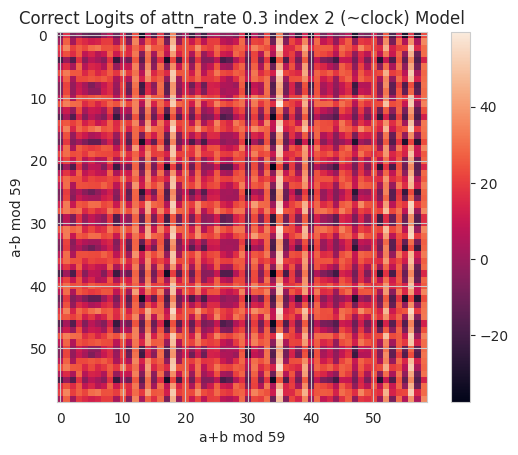

In [ ]:
plt.imshow(get_correct_logits_sum_diff_index(all_models[0.3][2]).detach().numpy())
plt.title('Correct Logits of attn_rate 0.3 index 2 (~clock) Model')
plt.xlabel(f'a+b mod {MODULUS}')
plt.ylabel(f'a-b mod {MODULUS}')
plt.colorbar()
plt.show()

Showing signs of what we'd expect: dependance on a+b for clock model and dependance on a-b for pizza model. Both models seem to be dependant on both though.

## Learning Coefficient Estimation

In [ ]:
def make_rlct_evals(
    trainset: ModularArithmetic,
    num_draws=100,
    num_chains=5,
    num_cores=NUM_CORES,
    lr=1e-6,
    noise_level=1.0,
    weight_decay=3e-7,
    elasticity=100.0,
    repeats=5,
    pbar=False,
    device=torch.device(DEVICE),
):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True)
    optimizer_kwargs = dict(
        lr=lr,
        noise_level=noise_level,
        weight_decay=weight_decay,
        elasticity=elasticity,
        temperature="adaptive",
        num_samples=len(trainset),
    )

    def eval_rlct(model: nn.Module):
        return estimate_learning_coeff(
            model,
            trainloader,
            cross_entropy_last_token,
            SGLD,
            optimizer_kwargs,
            num_draws=num_draws,
            num_chains=num_chains,
            num_burnin_steps=0,
            num_steps_bw_draws=1,
            cores=num_cores,
            pbar=pbar,
            device=device
        )

    def eval_rlct_repeated(model):
        results = {f"rlct/{i}": eval_rlct(model).item() for i in range(repeats)}
        rlcts = list(results.values())
        results["rlct/mean"] = np.mean(rlcts).item()
        results["rlct/std"] = np.std(rlcts).item()

        return results

    return eval_rlct_repeated

In [ ]:
all_models

In [ ]:
trainset, testset = mod_data.factory_split()

In [ ]:
eval_rlct = make_rlct_evals(trainset=trainset)

In [ ]:
model_test = all_models[0.8][5]

In [ ]:
rlct_dict = eval_rlct(model_test)

In [ ]:
rlct_dict['rlct/mean']

10.553369540231428

In [ ]:
rlct_list = np.zeros((len(all_models.items()),))
rlct_list

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
rlct_dict = {}
for attn_rate, model_arr in all_models.items():
  for model in model_arr:
    eval = eval_rlct(model)
    try:
      rlct_dict[attn_rate] += [eval]
    except:
      rlct_dict[attn_rate] = [eval]

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [ ]:
rlct_dict

{0.7: [{'rlct/0': 0.2531618174901133,
   'rlct/1': 0.2770148616984668,
   'rlct/2': 0.30413224108675946,
   'rlct/3': 0.3217894309241949,
   'rlct/4': 0.24354857355020604,
   'rlct/mean': 0.2799293849499481,
   'rlct/std': 0.029619595695245658},
  {'rlct/0': 15.813119052846833,
   'rlct/1': 13.936127139694818,
   'rlct/2': 13.73898446086249,
   'rlct/3': 13.952232326071007,
   'rlct/4': 13.846441545029922,
   'rlct/mean': 14.257380904901016,
   'rlct/std': 0.7815685321810324},
  {'rlct/0': 0.19588976362316637,
   'rlct/1': 1.501546142682014,
   'rlct/2': -0.6877662904705527,
   'rlct/3': 3.9872856350424164,
   'rlct/4': 1.8513002824350226,
   'rlct/mean': 1.3696511066624133,
   'rlct/std': 1.5944952047375327},
  {'rlct/0': 4.971962192245642,
   'rlct/1': 4.19950332734129,
   'rlct/2': 3.8521074831716775,
   'rlct/3': 4.551719567838948,
   'rlct/4': 4.395828327700708,
   'rlct/mean': 4.394224179659653,
   'rlct/std': 0.37158990963537164},
  {'rlct/0': 9.285631256632799,
   'rlct/1': 8.4

In [ ]:
circ_rlct = []
for attn_rate, model_arr in all_models.items():
  for i in range(len(model_arr)):
    if 0 < rlct_dict[attn_rate][i]['rlct/mean'] < 1000:
      circ_rlct.append([circularity(PCA(model_arr[i].embed.W_E[:,:-1], 4)), rlct_dict[attn_rate][i]])

In [ ]:
for i in range(len(circ_rlct)):
  circ_rlct[i][1] = circ_rlct[i][1]['rlct/mean']

In [ ]:
for i in range(len(circ_rlct)):
  circ_rlct[i][0] = circ_rlct[i][0].item()

In [ ]:
circ_rlct = np.array(circ_rlct)

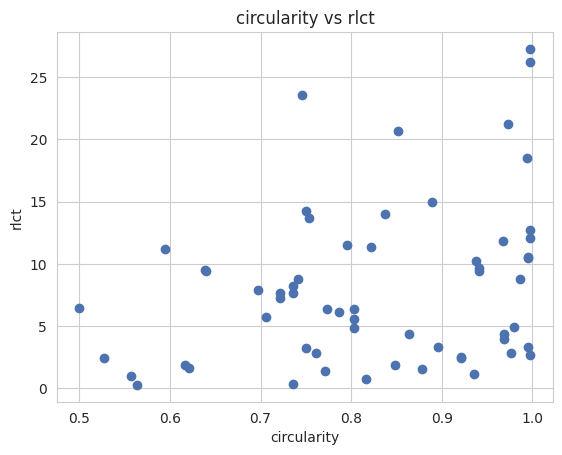

In [ ]:
plt.scatter(circ_rlct[:,0], circ_rlct[:,1])
plt.title('circularity vs rlct')
plt.xlabel('circularity')
plt.ylabel('rlct')
plt.show()